In [25]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

from progressbar import ProgressBar



import datetime
import calendar


%matplotlib inline


#need to make daily demand forecasts for each 18yr time block
def IndexOffset(df, yr):
    df.index = df.index+pd.offsets.DateOffset(years=yr)
    return df


In [26]:
#this function selects the scenario and makes a df to compare to preditcions and adjust
def DemandOffset(Demand_Forecast, MLR, YR, months, pred, Out_Demand, begdate, enddate, PrePeakFact, PostPeakFact):
    
    #select forecasts dates
    OGOut_Demand = Out_Demand.loc[str(YR)+begdate:str(YR)+enddate].copy()

    ForecastAnalysis = pd.DataFrame(Demand_Forecast['SLC_OutdoorDemand'][str(YR)+begdate:str(YR)+enddate])
    #Take the mean monthly values, these will be compared against mean monthly prediction/observeations
    ForecastAnalysis = ForecastAnalysis.resample('M').mean()
    ForecastAnalysis['Interpolated_Mean_Demand'] =ForecastAnalysis['SLC_OutdoorDemand'].copy()
    del ForecastAnalysis['SLC_OutdoorDemand']

    
    #print('The Forecast Length is: ', len(ForecastAnalysis))
     
    df = copy.deepcopy(MLR)
    newdf = []
    #Get the actual mean monthly prediction/observation
    for i in months:
        df[i].index =df[i].index.year
        df[i] = df[i].loc[YR]
        newdf = newdf + df[i][pred].to_list()
    #add the observed/predictions to Forecast df 
    #Offset the date in ForecastAnalysis to begin putting data back together
    #Need to add indices/copy values to match new Out_Demands  

    ForecastAnalysis.index = ForecastAnalysis.index - pd.DateOffset(days=15)

    ForecastAnalysis2 = ForecastAnalysis.copy()
    ForecastAnalysis2.index = ForecastAnalysis2.index - pd.DateOffset(days=1)
    ForecastAnalysis2.loc[:str(YR)+'-07-31'] =ForecastAnalysis2.loc[:str(YR)+'-07-31']*PrePeakFact[0]
    ForecastAnalysis2.loc[str(YR)+'-07-31':] =ForecastAnalysis2.loc[str(YR)+'-07-31':]*PostPeakFact[0]
    
    ForecastAnalysis3 = ForecastAnalysis.copy()
    ForecastAnalysis3.index = ForecastAnalysis3.index + pd.DateOffset(days=1)
    ForecastAnalysis3.loc[:str(YR)+'-07-31'] =ForecastAnalysis3.loc[:str(YR)+'-07-31']*PrePeakFact[2]
    ForecastAnalysis3.loc[str(YR)+'-07-31':] =ForecastAnalysis3.loc[str(YR)+'-07-31':]*PostPeakFact[2]    
    
    ForecastAnalysis4 = ForecastAnalysis.copy()
    ForecastAnalysis4.index = ForecastAnalysis4.index + pd.DateOffset(days=2)
    ForecastAnalysis4.loc[:str(YR)+'-07-31'] =ForecastAnalysis4.loc[:str(YR)+'-07-31']*PrePeakFact[3]
    ForecastAnalysis4.loc[str(YR)+'-07-31':] =ForecastAnalysis4.loc[str(YR)+'-07-31':]*PostPeakFact[3]  
    
    ForecastAnalysis.loc[:str(YR)+'-07-31'] =ForecastAnalysis.loc[:str(YR)+'-07-31']*PrePeakFact[1]
    ForecastAnalysis.loc[str(YR)+'-07-31':] =ForecastAnalysis.loc[str(YR)+'-07-31':]*PostPeakFact[1] 
    
    ForecastAnalysis = ForecastAnalysis.append(ForecastAnalysis2).sort_index() 
    ForecastAnalysis = ForecastAnalysis.append(ForecastAnalysis3).sort_index() 
    ForecastAnalysis = ForecastAnalysis.append(ForecastAnalysis4).sort_index()
    ForecastAnalysis['Goal']= newdf 
   
    #Find the difference to offset the new predictions
    ForecastAnalysis['Diff'] = ForecastAnalysis['Goal'] - ForecastAnalysis['Interpolated_Mean_Demand']
    
    
    #set Forecast1 to same index as Out_Demand
    Out_Demand = pd.DataFrame(Out_Demand[pred][str(YR)+begdate:str(YR)+enddate]) 
    ForecastAnalysis.index = Out_Demand.index
    
    
    #Adjust/offset the MLR_Out_Demand to fix the mean monthly demand (make very close to predictions/observations)
    Out_Demand[pred] = Out_Demand[pred]+ ForecastAnalysis['Diff']/2
    
    #make non zero values zero
    Out_Demand[Out_Demand<0]=0
    #show the modified outdemand as part of the forecast stats
    ForecastAnalysis['OGOut_Demand'] = OGOut_Demand[pred]
    ForecastAnalysis['NewOut_Demand'] = Out_Demand[pred]
    #make non zero values zero
    print('Analysis of the means:')
    print(pd.DataFrame(ForecastAnalysis))
    
    return Out_Demand

def DemandIterationAllyrs(iteration, DemandPlot, Demand_Forecast, MLR, YR, months, pred, Out_Demand, begdate, enddate, DemandOffset, Years, PrePeakFact, PostPeakFact):
    
    #This function evaluates the iteratted means with the predicted means to modify the interpolation to match mean monthly predictions
    Out_Demand2 = DemandOffset(Demand_Forecast, MLR, YR, months, pred, Out_Demand, begdate, enddate, PrePeakFact, PostPeakFact)
    #print('The new forecast monthly means are:')
    #print(Out_Demand2)
    
    Out_Demand3 = Out_Demand2.copy()

   # print('OutDemand3 Before adding days is ')
    #print(Out_Demand3.loc[str(YR)+'-4-1': str(YR)+"-5-30"])
    #interpolate between end of months to have better daily data
    Out_Demand3 = Out_Demand3.reindex(pd.date_range(start=Out_Demand3.index.min(),
                                                      end=Out_Demand3.index.max(),
                                                      freq='3D'))
    #print('OutDemand3 After adding 3days is ')
    #print(Out_Demand3.loc[str(YR)+'-4-1': str(YR)+"-5-30"])
    Y = [Years]
    for y in Y:
        Out_Demand3[pred].loc[str(y)+'-1-01': str(y)+"-3-30"] = 0
        Out_Demand3[pred].loc[str(y)+'-11-01': str(y)+"-12-30"] = 0
        #the spline order = 2 adds some demand pre April, however I think this is good as it adds a bit
    #of demand variability in the early months--Use this for the low flow scenario
    Out_Demand3 = Out_Demand3.interpolate(method= 'spline', order = 3)
    
    Out_Demand3 = Out_Demand3.reindex(pd.date_range(start=Out_Demand3.index.min(),
                                                      end=Out_Demand3.index.max(),
                                                      freq='2D'))
    Y = [Years]
    for y in Y:
        Out_Demand3[pred].loc[str(y)+'-1-01': str(y)+"-3-30"] = 0
        Out_Demand3[pred].loc[str(y)+'-11-01': str(y)+"-12-30"] = 0
    Out_Demand3 = Out_Demand3.interpolate(method= 'spline', order = 3)
    
    Out_Demand3 = Out_Demand3.reindex(pd.date_range(start=Out_Demand3.index.min(),
                                                      end=Out_Demand3.index.max(),
                                                      freq='1D'))
    Y = [Years]
    for y in Y:
        Out_Demand3[pred].loc[str(y)+'-1-01': str(y)+"-3-30"] = 0
        Out_Demand3[pred].loc[str(y)+'-11-01': str(y)+"-12-30"] = 0
    Out_Demand3 = Out_Demand3.interpolate(method= 'spline', order = 3)

    Out_Demand3['SLC_OutdoorDemand'] = Out_Demand3[pred].copy()
    del Out_Demand3[pred]

    Out_Demand3 = pd.DataFrame(Out_Demand3)

    #Fix interpolations errors with demands
    Out_Demand3.SLC_OutdoorDemand.loc[str(YR)+'-1-01': str(YR)+"-3-30"] = 0
    Out_Demand3.SLC_OutdoorDemand.loc[str(YR)+'-11-01': str(YR)+"-12-30"] = 0
    Out_Demand3[Out_Demand3 < 0]=0
    
    #make a plot of the iterations
    DemandPlot['Iteration_'+str(iteration)]=Out_Demand3.SLC_OutdoorDemand.loc[str(YR)+'-4-01': str(YR)+"-11-15"]
    


    #Update the water demand time series with forecasted values
    Demand_Forecast.update(Out_Demand3)
    return Demand_Forecast, Out_Demand2, DemandPlot


def Obs_Demand(Demand_Forecast, yr, Scenario, cities):
    #need to make observed demand dataframes for goldsim
    sim = Demand_Forecast.loc[str(yr)+'-01-01':str(yr)+'-12-30'].copy()
    yroffset = 2021-yr
    sim.index = sim.index + pd.DateOffset(years = yroffset)
    sim = sim[~sim.index.duplicated(keep='first')]
    #print(sim.loc['2021-02-01':'2021-03-01'])
    Demand_Forecast.update(sim)
    for i in cities:
        Demand_Forecast[i] = Demand_Forecast['SLC_OutdoorDemand'].copy()

    #Save dataframe
    Demand_Forecast.to_excel('C:/Users/rjohnson18/Box/Dissertation/Paper2/Data/Demand_Forecast/'+Scenario+'.xlsx')
    print('Done with simulation demand set up')

In [27]:
p = Path('C:/Users/rjohnson18/Box/Dissertation/Paper1/Data/Processed_Training_Data')
#Load historical data
slc = {i.stem[0:3] : pd.read_excel(i) for i in p.glob('**/*.xlsx')}

#load model predictions and place into desired year
MLR2 = np.load('C:/Users/rjohnson18/Box/Dissertation/Paper1/Python/ModelOutput/Slc_Pred.npy',allow_pickle=True).item()
MLR = np.load('C:/Users/rjohnson18/Box/Dissertation/Paper1/Python/ModelOutput/Slc_Pred_Low_Ave_High_WY.npy',allow_pickle=True).item()
MLR_E = np.load('C:/Users/rjohnson18/Box/Dissertation/Paper1/Python/ModelOutput/Slc_Pred_Uncertainty.npy', allow_pickle =True).item()




In [28]:
MLR_E['Apr']

,Year,y_test,y_pred,y_pred_lower,y_pred_upper,y_test_tot,y_pred_tot,y_pred_lower_tot,y_pred_upper_tot
Date,,,,,,,,,
2008-04-30,2008,9.222,19.508404,14.798673,24.259356,160.030,145.299068,140.589338,150.050021
2015-04-30,2015,26.980,41.101437,20.734183,61.907437,139.970,153.009799,132.642545,173.815799
2017-04-30,2017,0.000,0.533604,0.000000,16.551459,120.354,108.475593,107.941989,124.493448


<AxesSubplot:>

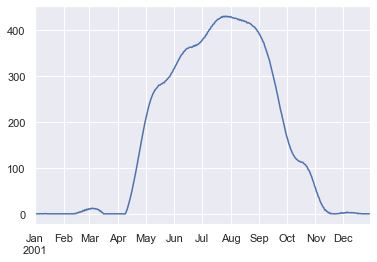

In [29]:

#monthly demand factors
#PrePeakFact = [.985,.995,1.005,1.015]
#PostPeakFact = [1.015,1.005,.995,.985]

PrePeakFact = [1,1,1,1]
PostPeakFact = [1,1,1,1]


#need to subtract indoor demands from outdoor and make indoor months 0
Ind_Mon = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']

#make indoor df
Ind_Dem = pd.DataFrame()

for i in Ind_Mon:
    slc[i].index = slc[i]['Year']
    slc[i] = slc[i][str(i)+'_gpcd']
    slc[i] = pd.DataFrame(slc[i])
    Ind_Dem = pd.concat([Ind_Dem, slc[i].copy()], axis=1)
    
    #now need to set slc indoor demand to zero for input into outdoor demands
    slc[i][str(i)+'_gpcd'] = 0
    slc[i] = slc[i].reset_index()

    
#now need to get row averages
#Ind_Dem = Ind_Dem.loc[2000:]
Ind_Dem['Mean_Indoor'] = Ind_Dem.mean(axis=1)
ave_ind = list(Ind_Dem['Mean_Indoor'])



Demand_Forecast = pd.DataFrame()
Demand_Month = pd.DataFrame()
#rename the gpcd column
for i in slc:
    slc[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slc[i]['Obs_gpcd'] = slc[i]['Obs_gpcd'] - ave_ind
    slc[i].loc[slc[i]['Obs_gpcd'] < 0, 'Obs_gpcd'] = 0
    slc[i]=slc[i].set_index('Year')
    slc[i]=slc[i]['Obs_gpcd']
    slc[i]=pd.DataFrame(slc[i].loc[2000:])
    
    #input the middle of month date to set up regressions between
    slc[i]['Month'] = pd.to_datetime(i, format='%b').month
    slc[i]['Year'] = slc[i].index
    slc[i]['Date'] = slc[i]['Year'].map(str)+ '-' + slc[i]['Month'].map(str) 
    slc[i]['Date'] = pd.to_datetime(pd.to_datetime(slc[i]['Date']), format="%Y%m") + MonthEnd(1)
    slc[i].index = slc[i]['Date']
    
    #Since this is the mean, it will form the middle of the month
    slc[i].index = slc[i].index - pd.DateOffset(days=15)
    
    #drop columns
    coldrop = ['Month', 'Year', 'Date']
    slc[i] = slc[i].drop(columns = coldrop)
    
    #Adjust when we want the mean to occur
    if i == 'Apr':
        slc[i].index = slc[i].index + pd.DateOffset(days=0)
    elif i == 'May':
        slc[i].index = slc[i].index - pd.DateOffset(days=0)
    elif i == 'Jun':
        slc[i].index = slc[i].index + pd.DateOffset(days=0)
    elif i == 'Jul':
        slc[i].index = slc[i].index + pd.DateOffset(days=0)
    elif i == 'Aug':
        slc[i].index = slc[i].index - pd.DateOffset(days=0)
    elif i == 'Sep':
        slc[i].index = slc[i].index - pd.DateOffset(days=0)
    elif i == 'Oct':
        slc[i].index = slc[i].index - pd.DateOffset(days=0)
    slc[i] = pd.DataFrame(slc[i])
    
    
    slc2=copy.deepcopy(slc)
    if i == 'Apr':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PrePeakFact[0]
    if i == 'May':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PrePeakFact[0]
    elif i == 'Jun':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PrePeakFact[0]
    elif i == 'Jul':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PrePeakFact[0]
    elif i == 'Aug':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PostPeakFact[0]
    elif i == 'Sep':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PostPeakFact[0]
    elif i == 'Oct':
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        slc2[i]= slc2[i]['Obs_gpcd']*PostPeakFact[0]
    else:
        slc2[i].index = slc2[i].index - pd.DateOffset(days=1)
        
    #This adds another data point to help with demand curve, at the end of month
    #This demand factors influences the 3rd week of the month
    slc3=copy.deepcopy(slc)
    if i == 'Apr':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PrePeakFact[2]
    elif i == 'May':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PrePeakFact[2]
    elif i == 'Jun':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PrePeakFact[2]
    elif i == 'Jul':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PrePeakFact[2]
    elif i == 'Aug':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PostPeakFact[2]
    elif i == 'Sep':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PostPeakFact[2]
    elif i == 'Oct':
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        slc3[i]= slc3[i]['Obs_gpcd']*PostPeakFact[2]
    else:
        slc3[i].index = slc3[i].index + pd.DateOffset(days=1)
        
        
    #This adds another data point to help with demand curve, at the end of month
    #This demand factor influences the last week of the month
    slc4=copy.deepcopy(slc)
    if i == 'Apr':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PrePeakFact[3]
    elif i == 'May':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PrePeakFact[3]
    elif i == 'Jun':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PrePeakFact[3]
    elif i == 'Jul':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PrePeakFact[3]
    elif i == 'Aug':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PostPeakFact[3]
    elif i == 'Sep':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PostPeakFact[3]
    elif i == 'Oct':
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        slc4[i]= slc4[i]['Obs_gpcd']*PostPeakFact[3]
    else:
        slc4[i].index = slc4[i].index + pd.DateOffset(days=2)
        
        
    if i == 'Apr':
        slc[i]= slc[i]['Obs_gpcd']*PrePeakFact[1]
    elif i == 'May':
        slc[i]= slc[i]['Obs_gpcd']*PrePeakFact[1]
    elif i == 'Jun':
        slc[i]= slc[i]['Obs_gpcd']*PrePeakFact[1]
    elif i == 'Jul':
        slc[i]= slc[i]['Obs_gpcd']*PrePeakFact[1]
    elif i == 'Aug':
        slc[i]= slc[i]['Obs_gpcd']*PostPeakFact[1]
    elif i == 'Sep':
        slc[i]= slc[i]['Obs_gpcd']*PostPeakFact[1]
    elif i == 'Oct':
        slc[i]= slc[i]['Obs_gpcd']*PostPeakFact[1]
    slc[i] = pd.DataFrame(slc[i])
        
    #connect DF's and drop duplicate indices
    slc[i] =pd.DataFrame(slc[i])
    Demand_Month = Demand_Month.append(pd.DataFrame(slc[i]))
    Demand_Month = Demand_Month.sort_index()
    slc2[i] =pd.DataFrame(slc2[i])
    slc3[i] =pd.DataFrame(slc3[i])
    slc4[i] =pd.DataFrame(slc4[i])
    slc[i] = slc[i].append(slc2[i]).sort_index()
    slc[i] = slc[i].append(slc3[i]).sort_index()
    slc[i] = slc[i].append(slc4[i]).sort_index()
   # slc[i] = slc[i][~slc[i].index.duplicated(keep='first')]    
        
    Demand_Forecast = Demand_Forecast.append(pd.DataFrame(slc[i]))
    Out_Demand=Demand_Forecast.copy()
    Out_Demand = Out_Demand.sort_index()
    
Demand_Forecast = Demand_Forecast.sort_index()
Demand_Forecast['SLC_OutdoorDemand'] = Demand_Forecast['Obs_gpcd'].copy()
del Demand_Forecast['Obs_gpcd']

#interpolate between end of months to have better daily data
Demand_Forecast = Demand_Forecast.reindex(pd.date_range(start=Demand_Forecast.index.min(),
                                                  end=Demand_Forecast.index.max(),
                                                  freq='3D'))
Demand_Forecast = Demand_Forecast.interpolate(method='spline', order=5) 

#now linearly interpolate between values
Demand_Forecast = Demand_Forecast.reindex(pd.date_range(start=Demand_Forecast.index.min(),
                                                  end=Demand_Forecast.index.max(),
                                                  freq='2D'))
Demand_Forecast = Demand_Forecast.interpolate(method='spline', order=5) 

Demand_Forecast = Demand_Forecast.reindex(pd.date_range(start=Demand_Forecast.index.min(),
                                                  end=Demand_Forecast.index.max(),
                                                  freq='1D'))
Demand_Forecast = Demand_Forecast.interpolate(method='spline', order=5) 

#Fix interpolations errors with demands
Demand_Forecast[Demand_Forecast < 0]=0

#2006 and 2010 data are missing. need to fill them with nearby demands with nearby years
Demand2006 = Demand_Forecast.loc['2005-1-1':'2005-12-30'].copy()
Demand2010 = Demand_Forecast.loc['2009-1-1':'2009-12-30'].copy() 

#add a year to the index
Demand2006 = IndexOffset(Demand2006, 1)
Demand2010 = IndexOffset(Demand2010, 1)

#need to updated the rows in Demand_Forecast now
Demand_Forecast.update(Demand2006)
Demand_Forecast.update(Demand2010)

Demand_Forecast.SLC_OutdoorDemand.loc['2001-1-01': "2001-12-30"].plot.line()

In [30]:
'''
This step ensures the mean demands are retained.

'''
months = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
Year1 = list(np.arange(2000,2006,1))
Year2 = [2007, 2008, 2009]
Year3 = list(np.arange(2011,2018,1))
Years = Year1+Year2+Year3
Year = [2003]
iterations = list(np.arange(1,15,1))
DemandPlot = pd.DataFrame()
for i in Year:
    Out_Demand2 = Out_Demand.copy()
    for j in iterations:
        DemandPlot['Iteration_'+str(j)] = 0
        Demand_Forecast, Out_Demand2, DemandPlot =DemandIterationAllyrs(j, DemandPlot, Demand_Forecast, slc, i, months, 'Obs_gpcd', 
                            Out_Demand2, '-01-01', '-12-30',DemandOffset,i, PrePeakFact, PostPeakFact)
        


Analysis of the means:
            Interpolated_Mean_Demand     Goal       Diff  OGOut_Demand  \
Date                                                                     
2003-01-15                  1.507644    0.000  -1.507644         0.000   
2003-01-16                  1.507644    0.000  -1.507644         0.000   
2003-01-17                  1.507644    0.000  -1.507644         0.000   
2003-01-18                  1.507644    0.000  -1.507644         0.000   
2003-02-12                  0.573693    0.000  -0.573693         0.000   
2003-02-13                  0.573693    0.000  -0.573693         0.000   
2003-02-14                  0.573693    0.000  -0.573693         0.000   
2003-02-15                  0.573693    0.000  -0.573693         0.000   
2003-03-15                  1.484792    0.000  -1.484792         0.000   
2003-03-16                  1.484792    0.000  -1.484792         0.000   
2003-03-17                  1.484792    0.000  -1.484792         0.000   
2003-03-18     

Analysis of the means:
            Interpolated_Mean_Demand     Goal      Diff  OGOut_Demand  \
Date                                                                    
2003-01-15                  1.270985    0.000 -1.270985      0.000000   
2003-01-16                  1.270985    0.000 -1.270985      0.000000   
2003-01-17                  1.270985    0.000 -1.270985      0.000000   
2003-01-18                  1.270985    0.000 -1.270985      0.000000   
2003-02-12                  0.000000    0.000  0.000000      0.000000   
2003-02-13                  0.000000    0.000  0.000000      0.000000   
2003-02-14                  0.000000    0.000  0.000000      0.000000   
2003-02-15                  0.000000    0.000  0.000000      0.000000   
2003-03-15                  0.000000    0.000  0.000000      0.000000   
2003-03-16                  0.000000    0.000  0.000000      0.000000   
2003-03-17                  0.000000    0.000  0.000000      0.000000   
2003-03-18                  

Analysis of the means:
            Interpolated_Mean_Demand     Goal      Diff  OGOut_Demand  \
Date                                                                    
2003-01-15                  1.270985    0.000 -1.270985      0.000000   
2003-01-16                  1.270985    0.000 -1.270985      0.000000   
2003-01-17                  1.270985    0.000 -1.270985      0.000000   
2003-01-18                  1.270985    0.000 -1.270985      0.000000   
2003-02-12                  0.000000    0.000  0.000000      0.000000   
2003-02-13                  0.000000    0.000  0.000000      0.000000   
2003-02-14                  0.000000    0.000  0.000000      0.000000   
2003-02-15                  0.000000    0.000  0.000000      0.000000   
2003-03-15                  0.000000    0.000  0.000000      0.000000   
2003-03-16                  0.000000    0.000  0.000000      0.000000   
2003-03-17                  0.000000    0.000  0.000000      0.000000   
2003-03-18                  

<Figure size 432x288 with 0 Axes>

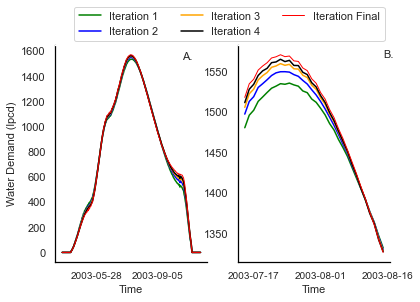

In [35]:
#conver to liter for ASCE
#DemandPlot = DemandPlot*3.78541

fig = plt.figure()
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(6, 4)
labelsize = 11

gal_to_l = 3.785

ax[0].set_facecolor('white')
ax[0].plot(DemandPlot.Iteration_1*gal_to_l, label = 'Iteration 1', color = 'green')
ax[0].plot(DemandPlot.Iteration_2*gal_to_l, label = 'Iteration 2', color = 'blue')
ax[0].plot(DemandPlot.Iteration_3*gal_to_l, label = 'Iteration 3', color = 'orange')
ax[0].plot(DemandPlot.Iteration_4*gal_to_l, label = 'Iteration 4', color = 'black')
ax[0].plot(DemandPlot.Iteration_14*gal_to_l, label = 'Iteration Final', linewidth = 1, color = 'red')

ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].set_xlabel('Time', size = labelsize)
ax[0].set_ylabel('Water Demand (lpcd)', size = labelsize)
ax[0].text(pd.to_datetime('2003-10-15'),405*gal_to_l , "A.", size = labelsize)
ax[0].tick_params(axis='x', which='major', labelsize=10)



ax[1].set_facecolor('white')
ax[1].plot(DemandPlot.Iteration_1.loc['2003-07-15':'2003-08-15']*gal_to_l, label = 'Iteration 1', color = 'green')
ax[1].plot(DemandPlot.Iteration_2.loc['2003-07-15':'2003-08-15']*gal_to_l, label = 'Iteration 2', color = 'blue')
ax[1].plot(DemandPlot.Iteration_3.loc['2003-07-15':'2003-08-15']*gal_to_l, label = 'Iteration 3', color = 'orange')
ax[1].plot(DemandPlot.Iteration_4.loc['2003-07-15':'2003-08-15']*gal_to_l, label = 'Iteration 4', color = 'black')
ax[1].plot(DemandPlot.Iteration_14.loc['2003-07-15':'2003-08-15']*gal_to_l, label = 'Iteration Final', linewidth = 1, color = 'red')

ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].set_xlabel('Time', size = labelsize)
ax[1].text(pd.to_datetime('2003-08-15'),414*gal_to_l , "B.", size = labelsize)
ax[1].tick_params(axis='x', which='major', labelsize=10)

leg = ax[1].legend(bbox_to_anchor=(1, 1.2), loc = 'upper right', ncol = 3)
frame = leg.get_frame()
frame.set_facecolor('white')
fig.savefig('C:/Users/rjohnson18/Box/Dissertation/Paper2/Figures/Downscaling_Iterations.pdf', bbox_inches='tight',pad_inches=.15)   
fig.savefig('C:/Users/rjohnson18/Box/Dissertation/Paper2/Figures/Downscaling_Iterations.png',dpi = 300, bbox_inches='tight',pad_inches=.15)   

In [36]:

#need to make daily demand forecasts for each 18yr time block
Demand_Forecast2017 = IndexOffset(Demand_Forecast.copy(), 17)
Demand_Forecast2034 = IndexOffset(Demand_Forecast.copy(), 34)
Demand_Forecast2051 = IndexOffset(Demand_Forecast.copy(), 51)
Demand_Forecast2068 = IndexOffset(Demand_Forecast.copy(), 68)
Demand_Forecast2085 = IndexOffset(Demand_Forecast.copy(), 85)

#Now append to create time series
Demand_Forecast = Demand_Forecast.append(Demand_Forecast2017)
Demand_Forecast = Demand_Forecast.append(Demand_Forecast2034)
Demand_Forecast = Demand_Forecast.append(Demand_Forecast2051)
Demand_Forecast = Demand_Forecast.append(Demand_Forecast2068)
Demand_Forecast = Demand_Forecast.append(Demand_Forecast2085)

Demand_Forecast = Demand_Forecast.loc['2000-10-01' :'2099-1-15']
Demand_Forecast = Demand_Forecast[~Demand_Forecast.index.duplicated(keep='first')]
#make sure date range is correct
DateRange = pd.date_range(start="2000-10-01",end="2098-12-31")
Demand_Forecast['Time'] = DateRange
Demand_Forecast.index = Demand_Forecast['Time']
del Demand_Forecast['Time']

Demand_Forecast = pd.DataFrame(Demand_Forecast)
#Since we did a cubic spline interpolation, all values need to be above zero
Demand_Forecast[Demand_Forecast < 0]=0

In [ ]:
MLR['Apr']

In [67]:
MLR_E['Jun']

,Year,y_test,y_pred,y_pred_lower,y_pred_upper,y_test_tot,y_pred_tot,y_pred_lower_tot,y_pred_upper_tot
Date,,,,,,,,,
2008-06-30,2008,252.512,254.158191,214.982524,293.196992,403.32,379.948856,340.773188,418.987657
2015-06-30,2015,246.680,258.712664,228.001702,289.846501,359.67,370.621025,339.910064,401.754863
2017-06-30,2017,309.616,281.984760,234.599193,329.625625,429.97,389.926749,342.541182,437.567615


In [110]:
#Make a prediction out DF
#original DF
#MLR = np.load('C:/Users/Ryan/Box/Dissertation/Paper1/Python/ModelOutput/Slc_Pred_Low_Ave_High_WY.npy',allow_pickle=True).item()
#DF w/error
MLR = np.load('C:/Users/rjohnson18/Box/Dissertation/Paper1/Python/ModelOutput/Slc_Pred_Uncertainty.npy', allow_pickle =True).item()
MLR_Out_Demand= pd.DataFrame()

#Select year to use (Drought = 2015, Average = 2017, Surplus = 2008)
Year = 2015

DemandPrediction = 'y_pred_lower'

Scenario = 'Drought_LowerD'

PrePeakFact = [1,1,1,1]
PostPeakFact = [1,1,1,1]

<AxesSubplot:>

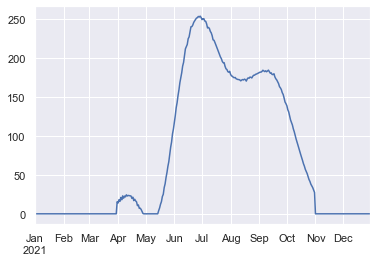

In [111]:


coldrop = ['y_pred_tot', 'Year', 'y_test', 'y_test_tot']
#need to make indoor months 0
for i in Ind_Mon:
    MLR[i][DemandPrediction] = 0

 #Adjust when we want the mean to occur
for i in months:
    
    if i == 'Apr':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'May':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'Jun':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'Jul':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'Aug':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'Sep':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    elif i == 'Oct':
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    else:
        MLR[i].index = MLR[i].index - pd.DateOffset(days=15)
    MLR[i] = pd.DataFrame(MLR[i])
    MLR[i] = MLR[i].drop(columns = coldrop)
    
    MLR2=copy.deepcopy(MLR)
    if i == 'Apr':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PrePeakFact[0]
    if i == 'May':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PrePeakFact[0]
    elif i == 'Jun':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PrePeakFact[0]
    elif i == 'Jul':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PrePeakFact[0]
    elif i == 'Aug':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PostPeakFact[0]
    elif i == 'Sep':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PostPeakFact[0]
    elif i == 'Oct':
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        MLR2[i]= MLR2[i][DemandPrediction]*PostPeakFact[0]
    else:
        MLR2[i].index = MLR2[i].index - pd.DateOffset(days=1)
        
    #This adds another data point to help with demand curve, at the end of month
    #This demand factors influences the 3rd week of the month
    MLR3=copy.deepcopy(MLR)
    if i == 'Apr':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PrePeakFact[2]
    elif i == 'May':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PrePeakFact[2]
    elif i == 'Jun':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PrePeakFact[2]
    elif i == 'Jul':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PrePeakFact[2]
    elif i == 'Aug':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PostPeakFact[2]
    elif i == 'Sep':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PostPeakFact[2]
    elif i == 'Oct':
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        MLR3[i]= MLR3[i][DemandPrediction]*PostPeakFact[2]
    else:
        MLR3[i].index = MLR3[i].index + pd.DateOffset(days=1)
        
        
    #This adds another data point to help with demand curve, at the end of month
    #This demand factor influences the last week of the month
    MLR4=copy.deepcopy(MLR)
    if i == 'Apr':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PrePeakFact[3]
    elif i == 'May':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PrePeakFact[3]
    elif i == 'Jun':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PrePeakFact[3]
    elif i == 'Jul':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PrePeakFact[3]
    elif i == 'Aug':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PostPeakFact[3]
    elif i == 'Sep':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PostPeakFact[3]
    elif i == 'Oct':
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        MLR4[i]= MLR4[i][DemandPrediction]*PostPeakFact[3]
    else:
        MLR4[i].index = MLR4[i].index + pd.DateOffset(days=2)
        
        
    if i == 'Apr':
        MLR[i]= MLR[i][DemandPrediction]*PrePeakFact[1]
    elif i == 'May':
        MLR[i]= MLR[i][DemandPrediction]*PrePeakFact[1]
    elif i == 'Jun':
        MLR[i]= MLR[i][DemandPrediction]*PrePeakFact[1]
    elif i == 'Jul':
        MLR[i]= MLR[i][DemandPrediction]*PrePeakFact[1]
    elif i == 'Aug':
        MLR[i]= MLR[i][DemandPrediction]*PostPeakFact[1]
    elif i == 'Sep':
        MLR[i]= MLR[i][DemandPrediction]*PostPeakFact[1]
    elif i == 'Oct':
        MLR[i]= MLR[i][DemandPrediction]*PostPeakFact[1]
        
    #connect DF's and drop duplicate indices
    MLR[i] =pd.DataFrame(MLR[i])
    Demand_Month = Demand_Month.append(pd.DataFrame(MLR[i]))
    Demand_Month = Demand_Month.sort_index()
    MLR2[i] =pd.DataFrame(MLR2[i])
    MLR3[i] =pd.DataFrame(MLR3[i])
    MLR4[i] =pd.DataFrame(MLR4[i])
    MLR[i] = MLR[i].append(MLR2[i]).sort_index()
    MLR[i] = MLR[i].append(MLR3[i]).sort_index()
    MLR[i] = MLR[i].append(MLR4[i]).sort_index()
 

#Cherry pick date range of interest, this is where you input a date

MLR_Out_Demand = MLR_Out_Demand.loc[str(Year)+'-01-01': str(Year)+'-12-30']
YearOffset = 2021-Year
for i in months:
    MLR[i].index = MLR[i].index + pd.DateOffset(years = YearOffset)
    MLR_Out_Demand = MLR_Out_Demand.append(MLR[i])
    
#Sort the df index 
MLR_Out_DemandM = MLR_Out_Demand.copy()
#print('MLR_Out_DemandM is:')
#print (MLR_Out_DemandM)
 
#interpolate between end of months to have better daily data
MLR_Out_Demand = MLR_Out_Demand.reindex(pd.date_range(start=MLR_Out_Demand.index.min(),
                                                  end=MLR_Out_Demand.index.max(),
                                                  freq='3D'))
#the spline order = 2 adds some demand pre April, however I think this is good as it adds a bit
#of demand variability in the early months--Use this for the low flow scenario
MLR_Out_Demand = MLR_Out_Demand.interpolate(method='spline', order = 3) 

#interpolate between end of months to have better daily data
MLR_Out_Demand = MLR_Out_Demand.reindex(pd.date_range(start=MLR_Out_Demand.index.min(),
                                                  end=MLR_Out_Demand.index.max(),
                                                  freq='2D'))
#the spline order = 2 adds some demand pre April, however I think this is good as it adds a bit
#of demand variability in the early months--Use this for the low flow scenario
MLR_Out_Demand = MLR_Out_Demand.interpolate(method='spline', order = 3) 

#interpolate between end of months to have better daily data
MLR_Out_Demand = MLR_Out_Demand.reindex(pd.date_range(start=MLR_Out_Demand.index.min(),
                                                  end=MLR_Out_Demand.index.max(),
                                                  freq='1D'))
#the spline order = 2 adds some demand pre April, however I think this is good as it adds a bit
#of demand variability in the early months--Use this for the low flow scenario
MLR_Out_Demand = MLR_Out_Demand.interpolate(method='spline', order = 3) 

MLR_Out_Demand['SLC_OutdoorDemand'] = MLR_Out_Demand[DemandPrediction].copy()
del MLR_Out_Demand[DemandPrediction]

#move the df to the desired date
#MLR_Out_Demand2021=MLR_Out_Demand.copy()
#MLR_Out_Demand2021 = IndexOffset(MLR_Out_Demand2021.copy(), YearOffset)
#MLR_Out_Demand2021 = MLR_Out_Demand2021[~MLR_Out_Demand2021.index.duplicated(keep='first')]

#make sure date range is correct!!! Need to add a leap year if/else statement
#DateRange = pd.date_range(start="2021-1-28",end="2021-12-30")
#MLR_Out_Demand2021['Time'] = DateRange- pd.DateOffset(days=15)
#MLR_Out_Demand2021.index = MLR_Out_Demand2021['Time']
#del MLR_Out_Demand2021['Time']

MLR_Out_Demand = pd.DataFrame(MLR_Out_Demand)
MLR_Out_Demand[MLR_Out_Demand < 0]=0

#Fix interpolations errors with demands
MLR_Out_Demand.SLC_OutdoorDemand.loc['2021-1-01': "2021-3-30"] = 0
MLR_Out_Demand.SLC_OutdoorDemand.loc['2021-11-01': "2021-12-30"] = 0

#Plot figure of interpolation time of interestest
#MLR_Out_Demand2021.SLC_OutdoorDemand.loc['2021-1-01': "2021-12-30"].plot.line()

#Update the water demand time series with forecasted values
Demand_Forecast.update(MLR_Out_Demand.loc['2021-1-01': "2021-12-30"])
#print('MLR_Out_Demand is')
#print(MLR_Out_Demand)

MLR_Out_Demand.SLC_OutdoorDemand.loc['2021-1-01': "2021-12-30"].plot.line()
#Demand_Forecast.SLC_OutdoorDemand.loc['2013-01-01':'2016-12-30'].plot.line()

In [112]:
PrePeakFact = [1,1,1,1]
PostPeakFact = [1,1,1,1]

iterations = list(np.arange(1,15,1))
DemandPlot = pd.DataFrame()
Year = [2021]
for i in Year:
    MLR_Out_DemandM2 = MLR_Out_DemandM.copy()
    for j in iterations:
        Demand_Forecast, MLR_Out_DemandM2, DemandPlot =DemandIterationAllyrs(j,DemandPlot,Demand_Forecast , MLR, i, months, DemandPrediction, 
                            MLR_Out_DemandM2, '-01-01', '-12-30',DemandOffset,i, PrePeakFact, PostPeakFact)
        #Demand_Forecast, Out_Demand2, DemandPlot =DemandIterationAllyrs(j, DemandPlot, Demand_Forecast, slc, i, months, 'Obs_gpcd', 
         #                   Out_Demand2, '-01-01', '-12-30',DemandOffset,i, PrePeakFact, PostPeakFact)

<ipython-input-26-c38864e3deff>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  OGOut_Demand = Out_Demand.loc[str(YR)+begdate:str(YR)+enddate].copy()
<ipython-input-26-c38864e3deff>:57: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  Out_Demand = pd.DataFrame(Out_Demand[pred][str(YR)+begdate:str(YR)+enddate])


Analysis of the means:
            Interpolated_Mean_Demand        Goal       Diff  OGOut_Demand  \
Date                                                                        
2021-01-15                  0.000000    0.000000   0.000000      0.000000   
2021-01-16                  0.000000    0.000000   0.000000      0.000000   
2021-01-17                  0.000000    0.000000   0.000000      0.000000   
2021-01-18                  0.000000    0.000000   0.000000      0.000000   
2021-02-12                  0.000000    0.000000   0.000000      0.000000   
2021-02-13                  0.000000    0.000000   0.000000      0.000000   
2021-02-14                  0.000000    0.000000   0.000000      0.000000   
2021-02-15                  0.000000    0.000000   0.000000      0.000000   
2021-03-15                  0.498981    0.000000  -0.498981      0.000000   
2021-03-16                  0.498981    0.000000  -0.498981      0.000000   
2021-03-17                  0.498981    0.000000  -0.

2021-12-18       0.000000  
Analysis of the means:
            Interpolated_Mean_Demand        Goal       Diff  OGOut_Demand  \
Date                                                                        
2021-01-15                  0.000000    0.000000   0.000000      0.000000   
2021-01-16                  0.000000    0.000000   0.000000      0.000000   
2021-01-17                  0.000000    0.000000   0.000000      0.000000   
2021-01-18                  0.000000    0.000000   0.000000      0.000000   
2021-02-12                  0.000000    0.000000   0.000000      0.000000   
2021-02-13                  0.000000    0.000000   0.000000      0.000000   
2021-02-14                  0.000000    0.000000   0.000000      0.000000   
2021-02-15                  0.000000    0.000000   0.000000      0.000000   
2021-03-15                  0.115711    0.000000  -0.115711      0.000000   
2021-03-16                  0.115711    0.000000  -0.115711      0.000000   
2021-03-17               

Analysis of the means:
            Interpolated_Mean_Demand        Goal       Diff  OGOut_Demand  \
Date                                                                        
2021-01-15                  0.000000    0.000000   0.000000      0.000000   
2021-01-16                  0.000000    0.000000   0.000000      0.000000   
2021-01-17                  0.000000    0.000000   0.000000      0.000000   
2021-01-18                  0.000000    0.000000   0.000000      0.000000   
2021-02-12                  0.000000    0.000000   0.000000      0.000000   
2021-02-13                  0.000000    0.000000   0.000000      0.000000   
2021-02-14                  0.000000    0.000000   0.000000      0.000000   
2021-02-15                  0.000000    0.000000   0.000000      0.000000   
2021-03-15                  0.120712    0.000000  -0.120712      0.000000   
2021-03-16                  0.120712    0.000000  -0.120712      0.000000   
2021-03-17                  0.120712    0.000000  -0.

Analysis of the means:
            Interpolated_Mean_Demand        Goal       Diff  OGOut_Demand  \
Date                                                                        
2021-01-15                  0.000000    0.000000   0.000000      0.000000   
2021-01-16                  0.000000    0.000000   0.000000      0.000000   
2021-01-17                  0.000000    0.000000   0.000000      0.000000   
2021-01-18                  0.000000    0.000000   0.000000      0.000000   
2021-02-12                  0.000000    0.000000   0.000000      0.000000   
2021-02-13                  0.000000    0.000000   0.000000      0.000000   
2021-02-14                  0.000000    0.000000   0.000000      0.000000   
2021-02-15                  0.000000    0.000000   0.000000      0.000000   
2021-03-15                  0.120139    0.000000  -0.120139      0.000000   
2021-03-16                  0.120139    0.000000  -0.120139      0.000000   
2021-03-17                  0.120139    0.000000  -0.

<Figure size 432x288 with 0 Axes>

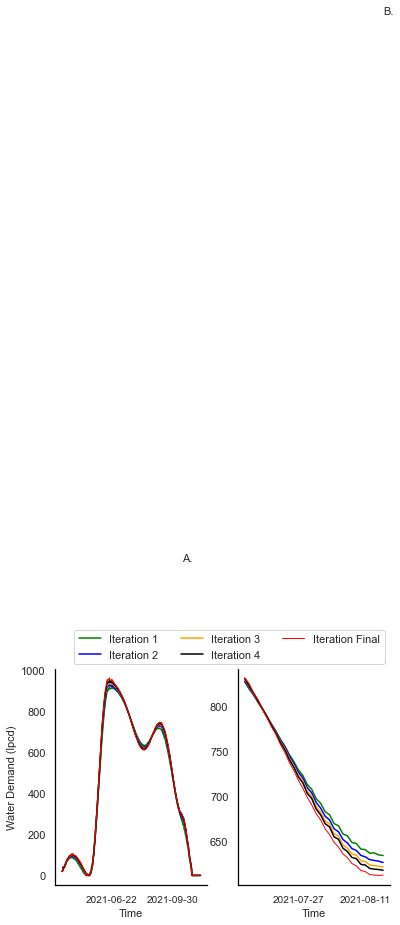

In [113]:
#conver to liter for ASCE
#DemandPlot = DemandPlot*3.78541

fig = plt.figure()
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(6, 4)
labelsize = 11

gal_to_l = 3.785

ax[0].set_facecolor('white')
ax[0].plot(DemandPlot.Iteration_1*gal_to_l, label = 'Iteration 1', color = 'green')
ax[0].plot(DemandPlot.Iteration_2*gal_to_l, label = 'Iteration 2', color = 'blue')
ax[0].plot(DemandPlot.Iteration_3*gal_to_l, label = 'Iteration 3', color = 'orange')
ax[0].plot(DemandPlot.Iteration_4*gal_to_l, label = 'Iteration 4', color = 'black')
ax[0].plot(DemandPlot.Iteration_14*gal_to_l, label = 'Iteration Final', linewidth = 1, color = 'red')

ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].set_xlabel('Time', size = labelsize)
ax[0].set_ylabel('Water Demand (lpcd)', size = labelsize)
ax[0].text(pd.to_datetime('2021-10-15'),405*gal_to_l , "A.", size = labelsize)
ax[0].tick_params(axis='x', which='major', labelsize=10)



ax[1].set_facecolor('white')
ax[1].plot(DemandPlot.Iteration_1.loc['2021-07-15':'2021-08-15']*gal_to_l, label = 'Iteration 1', color = 'green')
ax[1].plot(DemandPlot.Iteration_2.loc['2021-07-15':'2021-08-15']*gal_to_l, label = 'Iteration 2', color = 'blue')
ax[1].plot(DemandPlot.Iteration_3.loc['2021-07-15':'2021-08-15']*gal_to_l, label = 'Iteration 3', color = 'orange')
ax[1].plot(DemandPlot.Iteration_4.loc['2021-07-15':'2021-08-15']*gal_to_l, label = 'Iteration 4', color = 'black')
ax[1].plot(DemandPlot.Iteration_14.loc['2021-07-15':'2021-08-15']*gal_to_l, label = 'Iteration Final', linewidth = 1, color = 'red')

ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].set_xlabel('Time', size = labelsize)
ax[1].text(pd.to_datetime('2021-08-15'),414*gal_to_l , "B.", size = labelsize)
ax[1].tick_params(axis='x', which='major', labelsize=10)

leg = ax[1].legend(bbox_to_anchor=(1, 1.2), loc = 'upper right', ncol = 3)
frame = leg.get_frame()
frame.set_facecolor('white')

In [114]:
#need to add additional cities, just copy them
cities = ['MIll_OutdoorDemand', 'Holl_OutdoorDemand', 'CottHeigh_OutdoorDemand',
          'Murray', 'Sandy', 'Draper','WaterPro','Midvale', 'SouthSL', 'WhiteCity', 
            'Kearns', 'WestValley', 'Bluffdale', 'Copperton', 'Herriman', 'Magna',
            'Riverton', 'SoJordan', 'TayBen', 'Prison', 'WJordan', 'Lehi', 'AmericanFork',
            'PleasantGrove', 'Orem', 'Provo', 'Springville','SpanishFork']

for i in cities:
    Demand_Forecast[i] = Demand_Forecast['SLC_OutdoorDemand'].copy()

#Save dataframe
Demand_Forecast.to_excel('C:/Users/rjohnson18/Box/Dissertation/Paper2/Data/Demand_Forecast/'+Scenario+'.xlsx')

In [83]:
#Make forecast yr 2021 with observations to match to gage prediction accuracy
#Obs_Demand(Demand_Forecast, 2015, 'Drought', cities)
#Obs_Demand(Demand_Forecast, 2008, 'Surplus', cities)
#Obs_Demand(Demand_Forecast, 2017, 'Average', cities)

Done with simulation demand set up


In [95]:
#need to make observed demand dataframes for goldsim
Drought = Demand_Forecast.loc['2015-01-01':'2015-12-30'].copy()
Drought.index = Drought.index + pd.DateOffset(years = 6)
Demand_Forecast.update(Drought)
#need to add additional cities, just copy them
cities = ['MIll_OutdoorDemand', 'Holl_OutdoorDemand', 'CottHeigh_OutdoorDemand',
          'Murray', 'Sandy', 'Draper','WaterPro','Midvale', 'SouthSL', 'WhiteCity', 
            'Kearns', 'WestValley', 'Bluffdale', 'Copperton', 'Herriman', 'Magna',
            'Riverton', 'SoJordan', 'TayBen', 'Prison', 'WJordan', 'Lehi', 'AmericanFork',
            'PleasantGrove', 'Orem', 'Provo', 'Springville','SpanishFork']

for i in cities:
    Demand_Forecast[i] = Demand_Forecast['SLC_OutdoorDemand'].copy()

#Save dataframe
Demand_Forecast.to_excel('C:/Users/Ryan/Box/Dissertation/Paper2/Data/Demand_Forecast/OBS_Drought_Dem.xlsx')
print('Done with Drought demand set up')

#need to make observed demand dataframes for goldsim
Average = Demand_Forecast.loc['2017-01-01':'2017-12-30'].copy()
Average.index = Average.index + pd.DateOffset(years = 6)
Demand_Forecast.update(Drought)
#need to add additional cities, just copy them
cities = ['MIll_OutdoorDemand', 'Holl_OutdoorDemand', 'CottHeigh_OutdoorDemand',
          'Murray', 'Sandy', 'Draper','WaterPro','Midvale', 'SouthSL', 'WhiteCity', 
            'Kearns', 'WestValley', 'Bluffdale', 'Copperton', 'Herriman', 'Magna',
            'Riverton', 'SoJordan', 'TayBen', 'Prison', 'WJordan', 'Lehi', 'AmericanFork',
            'PleasantGrove', 'Orem', 'Provo', 'Springville','SpanishFork']

for i in cities:
    Demand_Forecast[i] = Demand_Forecast['SLC_OutdoorDemand'].copy()

#Save dataframe
Demand_Forecast.to_excel('C:/Users/Ryan/Box/Dissertation/Paper2/Data/Demand_Forecast/OBS_Drought_Dem.xlsx')

,SLC_OutdoorDemand
Time,
2021-01-01,1.782656
2021-01-02,1.685020
2021-01-03,1.623489
2021-01-04,1.591862
2021-01-05,1.412124
...,...
2021-12-26,1.181210
2021-12-27,0.521006
2021-12-28,0.588783
